In [1]:
from numpy import array
from pandas import Series
import numpy
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
from pandas import read_csv
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [3]:
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

In [4]:
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

In [5]:
# fixem random seed
numpy.random.seed(7)

dadesSau = read_csv('dadesBaells.csv', sep=';',header=0, index_col=0)
dataframe = pd.DataFrame(dadesSau.loc[dadesSau.index >= '2009-01-01']['Volum'])
dataset = dataframe.values
dataset = dataset.astype('float32')


In [6]:
# Diferenciem i normalitzem

diff_series = difference(dataset, 1)
diff_values = diff_series.values
diff_values = diff_values.reshape(len(diff_values), 1)

scaler = MinMaxScaler(feature_range=(0, 1))
datasetN = scaler.fit_transform(diff_values)
datasetN = [item for sublist in datasetN for item in sublist]


c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
# transformem les dades a format seqüencia d'entrada i seqüencia de sortida
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [8]:
def train_test (n_steps_in, n_steps_out, propTrainTest, dataset):
    
    n_steps_in, n_steps_out = n_steps_in, n_steps_out
    # split train test
    X, y = split_sequence(dataset, n_steps_in, n_steps_out)
    
    train_size = int(len(X) * propTrainTest)
    test_size = len(dataset) - train_size
    train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]
    train_Y, test_Y = y[0:train_size,:], y[train_size:len(y),:]
    
    return (train_X, test_X, train_Y, test_Y)

In [9]:
n_steps_in = 20
n_steps_out = 15
propTrainTest = 0.8
train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, datasetN)

In [11]:
# Fit regression model
regr_multirf = MultiOutputRegressor(SVR(kernel='rbf', C=75, gamma=0.1, epsilon=0.003))
regr_multirf.fit(train_X, train_Y)

MultiOutputRegressor(estimator=SVR(C=75, cache_size=200, coef0=0.0, degree=3, epsilon=0.003, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
           n_jobs=1)

In [12]:
# prediccions
testPredict = regr_multirf.predict(test_X)
n_test = len(test_X)
testPredict = inverse_transform(dataset, testPredict, scaler, n_test+2)
# invertim prediccions per tenir-les en l'escala original


In [13]:
import numpy as np
test_YR = test_Y
test_YR = inverse_transform(dataset, test_YR, scaler, n_test+2)
test_YR = np.array(test_YR)
testPredict = np.array(testPredict)

In [14]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calcul global de RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [19]:
RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
print(RMSE_TOT)

2.840760053019791


In [16]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_days)):
    headers.append('dia '+str(i+1))

print(RMSE_days)
headers.append('Total')
v = RMSE_days
ultim = v.append(RMSE_TOT)
table1 = tabulate([RMSE_days[0:5]], headers[0:5], tablefmt="fancy_grid")
table2 = tabulate([RMSE_days[5:10]], headers[5:10], tablefmt="fancy_grid")
table3 = tabulate([RMSE_days[10:16]], headers[10:16], tablefmt="fancy_grid")
#output
print(table1)
print(table2)
print(table3)

[0.36884520077664484, 0.7289671942939205, 1.0687850857156653, 1.3936758543400685, 1.7053301473120026, 2.0086188571092243, 2.2980291879126633, 2.5776258505613607, 2.8536553214864013, 3.133856468628836, 3.4166546022775917, 3.6971213045079523, 3.985174480337456, 4.278896603826766, 4.575183535370381]
╒══════════╤══════════╤═════════╤═════════╤═════════╕
│    dia 1 │    dia 2 │   dia 3 │   dia 4 │   dia 5 │
╞══════════╪══════════╪═════════╪═════════╪═════════╡
│ 0.368845 │ 0.728967 │ 1.06879 │ 1.39368 │ 1.70533 │
╘══════════╧══════════╧═════════╧═════════╧═════════╛
╒═════════╤═════════╤═════════╤═════════╤══════════╕
│   dia 6 │   dia 7 │   dia 8 │   dia 9 │   dia 10 │
╞═════════╪═════════╪═════════╪═════════╪══════════╡
│ 2.00862 │ 2.29803 │ 2.57763 │ 2.85366 │  3.13386 │
╘═════════╧═════════╧═════════╧═════════╧══════════╛
╒══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   dia 11 │   dia 12 │   dia 13 │   dia 14 │   dia 15 │   Total │
╞══════════╪══════════╪══════════

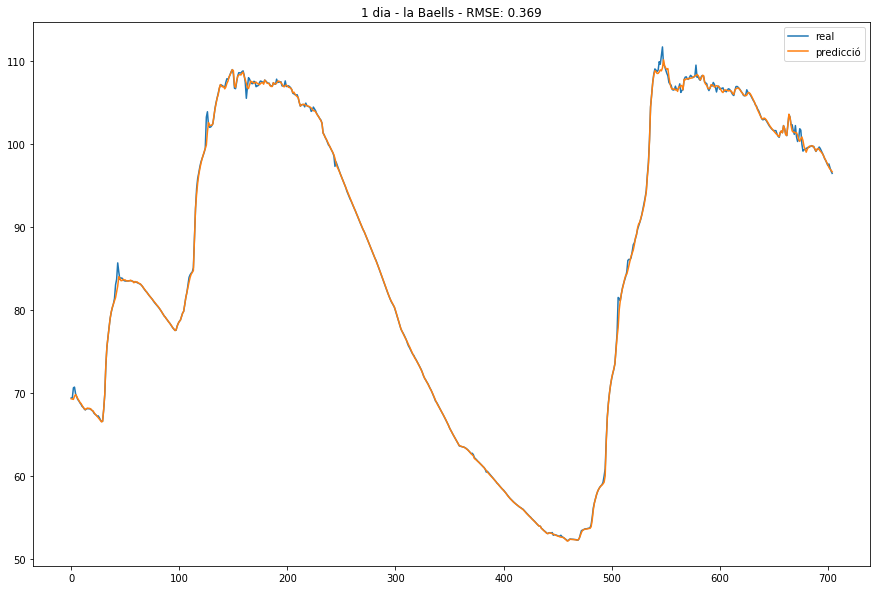

In [17]:
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - la Baells - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - la Baells - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - la Baells - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - la Baells - RMSE: '+str(round(RMSE_days[14],3))

plt.plot(dies[0][0], label='real')
plt.plot(dies[0][1], label='predicció')
plt.legend()
plt.title(title1)


plt.show()

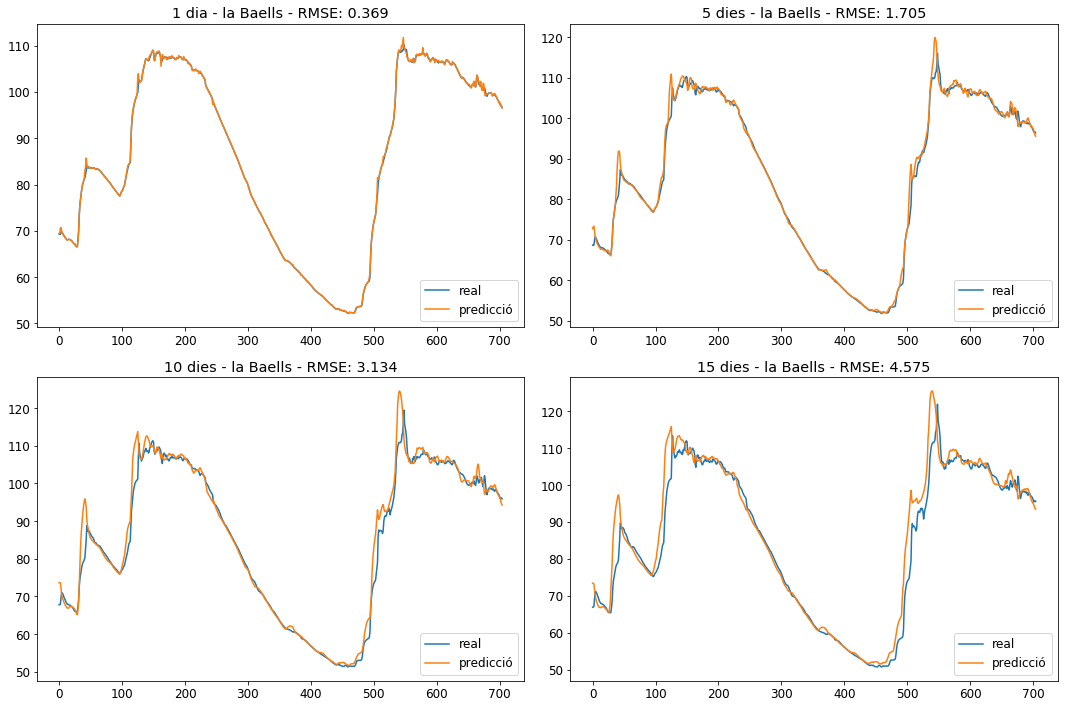

In [18]:
plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][1], label='real')
axes[0, 0].plot(dies[0][0], label='predicció')
axes[0, 0].legend(loc=4)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][1], label='real')
axes[0, 1].plot(dies[4][0], label='predicció')
axes[0, 1].legend(loc=4)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][1], label='real')
axes[1, 0].plot(dies[9][0], label='predicció')
axes[1, 0].legend(loc=4)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][1], label='real')
axes[1, 1].plot(dies[14][0], label='predicció')
axes[1, 1].legend(loc=4)


fig.tight_layout()
plt.show()